In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import corner
import pygtc

In [41]:
regioni_df = pd.read_csv('dpc-covid19-ita-regioni.csv')

In [42]:
nuovi_positivi_FVG = regioni_df[regioni_df['codice_regione'] == 6]['nuovi_positivi']

nuovi_positivi_FVG = np.array(nuovi_positivi_FVG) 

for i in range(len(nuovi_positivi_FVG)):
    
    if nuovi_positivi_FVG[i]<0.0 or nuovi_positivi_FVG[i] == np.nan:
        
        nuovi_positivi_FVG[i]= 0.0

Text(0.5, 1.0, 'Friuli Venezia Giulia')

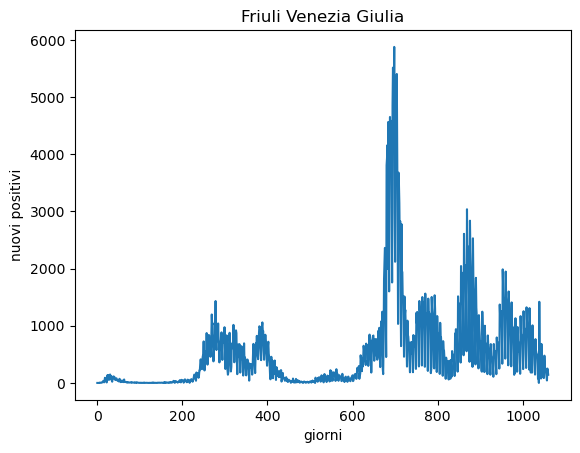

In [43]:
plt.plot(nuovi_positivi_FVG)
plt.xlabel('giorni')
plt.ylabel('nuovi positivi')
plt.title('Friuli Venezia Giulia')

Text(0.5, 1.0, 'Friuli Venezia Giulia')

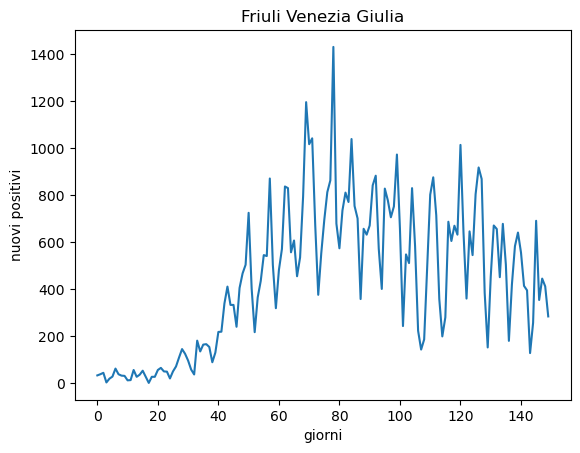

In [44]:
plt.plot(nuovi_positivi_FVG[200:350]) 
plt.xlabel('giorni')
plt.ylabel('nuovi positivi')
plt.title('Friuli Venezia Giulia')

In [45]:
NP_FVG = nuovi_positivi_FVG[200:350]

NP_FVG_cum = np.cumsum(NP_FVG) # andamento cumulativo

In [46]:
def gompertz(x, a, b, c):
    f = a * np.exp(-b * np.exp(-c * x))
    return f

In [47]:
x = np.arange(len(NP_FVG_cum))
y = NP_FVG_cum

In [48]:
popt, pcov = curve_fit(f = gompertz, xdata = x, ydata = y, p0 = [3 * max(y), 1, 1], maxfev = 800)

In [49]:
popt # parametri ottimali

array([7.90473928e+04, 8.74782459e+00, 2.56524960e-02])

In [50]:
pcov # matrice di covarianza dei parametri

array([[ 3.91015763e+05, -8.24535135e+01, -1.83236902e-01],
       [-8.24535135e+01,  2.59374373e-02,  4.86275428e-05],
       [-1.83236902e-01,  4.86275428e-05,  9.84676150e-08]])

Text(0, 0.5, 'nuovi positivi cumulativi')

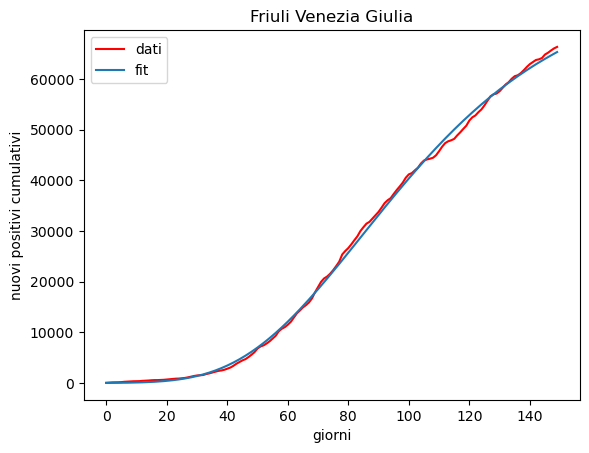

In [51]:
plt.plot(x, y, color = 'r', label = 'dati')
plt.plot(x, gompertz(x, popt[0], popt[1], popt[2]), label = 'fit')
plt.title('Friuli Venezia Giulia')
plt.legend()
plt.xlabel('giorni')
plt.ylabel('nuovi positivi cumulativi')

In [90]:
def log_prior(params):
    a, b, c = params
    if 75000 < a < 85000 and 5 < b < 15 and -0.03 < c < 0.3: 
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    a, b, c = params
    y_pred = gompertz(x, a, b, c)
    return np.sum(y * np.log(y_pred) - y_pred) 

def log_posterior(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(params, x, y) 
    logpos = logl+lp
    if not np.isfinite(logpos):
        return -np.inf
    return logl, logpos

In [91]:
pos =  popt + 1e-4 * np.random.randn(32, 3) 

nwalkers, ndim = pos.shape

print(pos.shape)

(32, 3)


100%|███████████████████████████████████| 20000/20000 [00:17<00:00, 1124.61it/s]


(20000, 32, 3)


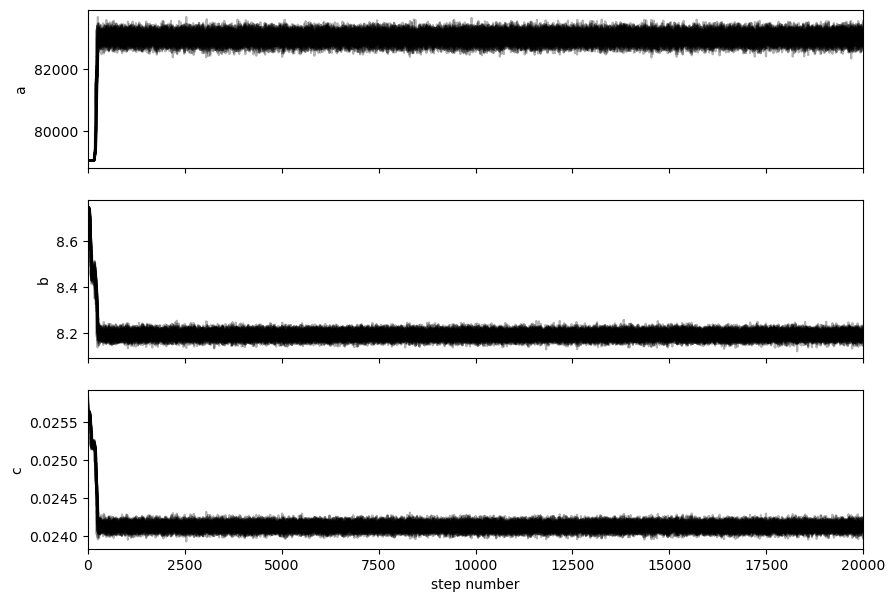

In [92]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y))  

sampler.run_mcmc(pos, 20000, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["a", "b", "c"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [80]:
tau = sampler.get_autocorr_time()
print(tau)

[214.36931102 181.80785277 208.54279902]


In [57]:
flat_samples = sampler.get_chain(discard=100, flat=True)

flat_blob = sampler.get_blobs(discard=100, flat=True)

print(flat_samples.shape)

(318400, 3)


In [58]:
Max_likelihood = np.argmax(flat_blob) 
print(flat_samples[Max_likelihood,:])


[8.30094683e+04 8.19105655e+00 2.41222422e-02]


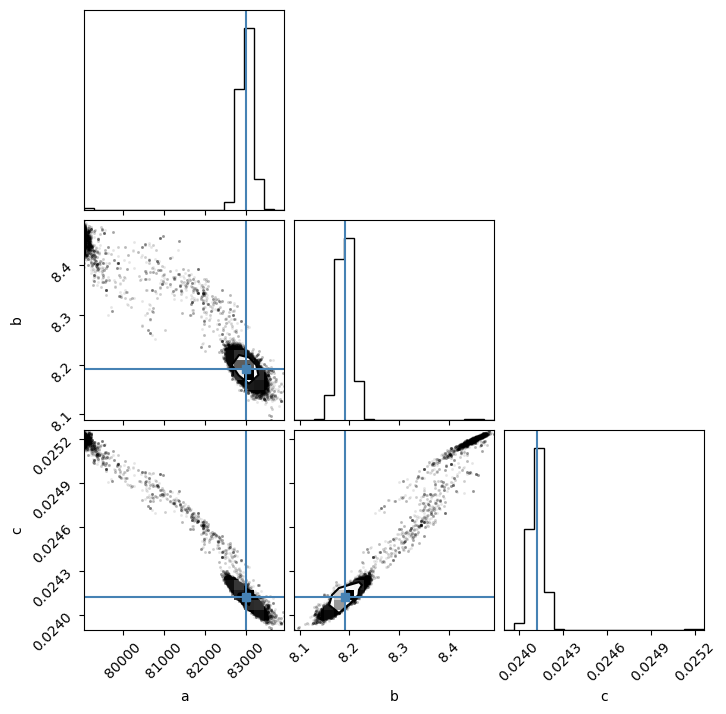

In [59]:
labels = ['a', 'b', 'c']
fig = corner.corner(flat_samples, labels=labels, truths=flat_samples[Max_likelihood,:])

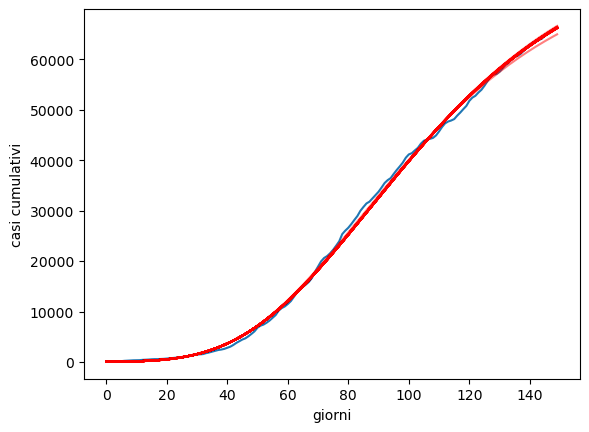

In [60]:
#plotta tutti i modelli
def plotter(samples, age = x, y = y):
    plt.plot(x, NP_FVG_cum, label='dati')
    samples = sampler.flatchain
    samples = flat_samples
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(x, gompertz(x, theta[0], theta[1], theta[2]), color="r", alpha=0.5)
    plt.xlabel('giorni')
    plt.ylabel('casi cumulativi')
plt.show()

plotter(samples)   

In [61]:
def sample_walkers(nsamples,flattened_chain,age = x):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flat_samples[draw]
    for i in thetas:
        mod = gompertz(age, i[0], i[1], i[2]) #model
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread

med_model, spread = sample_walkers(100,samples) #new_samples

In [62]:
new_best_fit_model = gompertz(x, flat_samples[Max_likelihood][0], flat_samples[Max_likelihood][1], flat_samples[Max_likelihood][2])


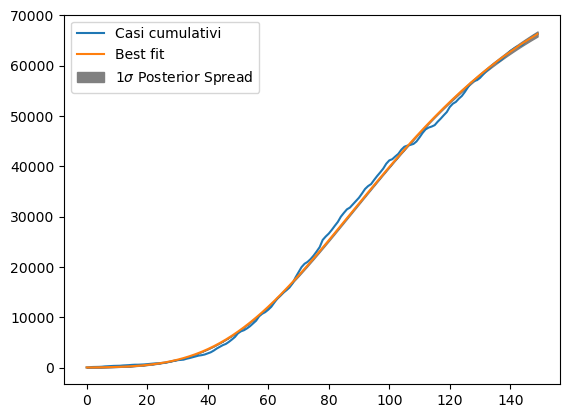

In [63]:
plt.plot(x, NP_FVG_cum,label='Casi cumulativi')
plt.plot(x, new_best_fit_model,label='Best fit')
plt.fill_between(x,med_model+spread,med_model-spread,color='grey',alpha=1,label=r'$1\sigma$ Posterior Spread')
plt.legend()